# NLP: Análisis de Sentimientos con VADER y RoBERTa
Análisis aplicado a descripciones de libros en español.

In [ ]:
#%pip install --upgrade pip

# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import nltk
from nltk.tokenize import PunktSentenceTokenizer, TreebankWordTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
warnings.filterwarnings("ignore")

# %pip show transformers
#%pip install --upgrade pip setuptools wheel

#%pip install tokenizers==0.13.3
#%pip show tokenizers
#%pip install transformers==4.30.2

Note: you may need to restart the kernel to use updated packages.Collecting tokenizers==0.13.3
  Using cached tokenizers-0.13.3.tar.gz (314 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build tokenizers



  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [62 lines of output]
      C:\Users\jesus\AppData\Local\Temp\pip-build-env-ew5epwoi\overlay\Lib\site-packages\setuptools\dist.py:759: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License :: OSI Approved :: Apache Software License
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              ********************************************************************************
      
      !!
        self._finalize_license_expression()
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd

Name: tokenizers
Version: 0.21.1
Summary: 
Home-page: https://github.com/huggingface/tokenizers
Author: Anthony MOI <m.anthony.moi@gmail.com>
Author-email: Nicolas Patry <patry.nicolas@protonmail.com>, Anthony Moi <anthony@huggingface.co>
License: 
Location: c:\Users\jesus\anaconda3\Lib\site-packages
Requires: huggingface-hub
Required-by: transformers
Note: you may need to restart the kernel to use updated packages.


In [11]:
# Cargar datos
file_path = "../data/processed/books.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace(".", "_").str.replace(":", "")
df = df[["blurb", "tags", "book_title"]].dropna(subset=["blurb"]).head(500)
df.head()

,blurb,tags,book_title
0,"Walter Ciszek, jesuita norteamericano, entró e...","abandonment-in-god, biography, catholic, chełm...",Caminando por valles oscuros: Memorias de un j...
1,<p>A chance encounter with a reproduction of R...,"_pilar, _sindy, abandonment-in-god, anxiety, a...",The Return of the Prodigal Son: A Story of Hom...
2,"A pesar de nuestros mejores esfuerzos, muchos ...","catholic, chełmińska, christ, christianity, de...",Liberado: Una Guía Práctica para la Liberación
3,Esta breve obra se compone de cartas escritas ...,"abandonment-in-god, catholic, christ, classics...",El Abandono en la Divina Providencia: Clásicos...
4,Resulta difícil no emocionarse varias veces al...,"adventures, atheism, biography, catholic, chur...",Una familia de bandidos en 1793


## Preprocesamiento NLP: Tokenización con NLTK

In [12]:
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("vader_lexicon")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [13]:
tokenizer_sent = PunktSentenceTokenizer()
tokenizer_words = TreebankWordTokenizer()
example = df["blurb"].iloc[65]
sentences = tokenizer_sent.tokenize(example)
tokens = []
for sentence in sentences:
    tokens.extend(tokenizer_words.tokenize(sentence))
print(tokens)
print(nltk.pos_tag(tokens))

['St', 'John', 'of', 'the', 'Cross', 'testifies', 'to', 'a', 'God', 'who', 'longs', 'to', 'meet', 'us', 'in', 'our', 'deepest', 'need', '.', 'Whilst', 'rejection', 'and', 'imprisonment', 'played', 'their', 'part', 'in', 'the', 'life', 'of', 'this', 'sixteenth-century', 'Spanish', 'friar', ',', 'John', "'s", 'poetry', 'and', 'prose', 'reveal', 'the', 'beauty', 'and', 'power', 'of', 'a', 'wondrous', 'God', '.', 'It', 'gives', 'us', 'courage', 'to', 'believe', 'in', 'the', 'possibility', 'of', 'change', 'in', 'our', 'own', 'lives', ',', 'however', 'unlikely', 'or', 'impossible', 'this', 'may', 'seem.', '<', 'br', '/', '>', 'Father', 'Iain', 'Matthew', 'uses', 'this', 'classic', 'inspirational', 'Christian', 'writing', 'as', 'his', 'starting', 'point', ',', 'and', 'offers', 'five', 'interpretations', 'which', 'make', 'its', 'richness', 'relevant', 'to', 'the', 'modern', 'reader', '.']
[('St', 'NNP'), ('John', 'NNP'), ('of', 'IN'), ('the', 'DT'), ('Cross', 'NNP'), ('testifies', 'NNS'), ('to

## Análisis de Sentimientos con VADER

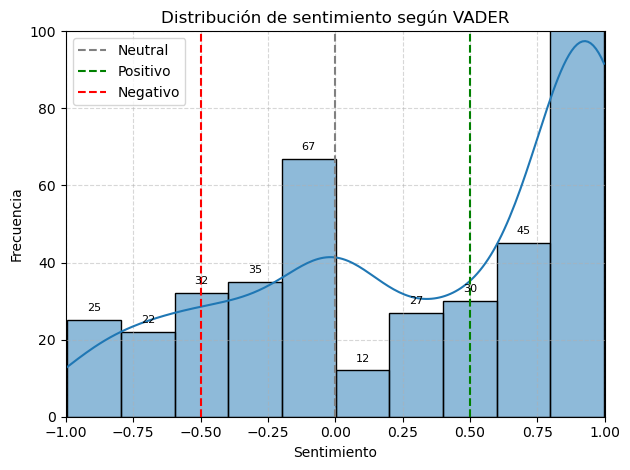

In [14]:
sia = SentimentIntensityAnalyzer()
pol_scores = {}
for i, row in df.iterrows():
    text = row["blurb"]
    scores = sia.polarity_scores(text)
    pol_scores[i] = scores
vaders = pd.DataFrame(pol_scores).T
vaders = pd.concat([df.reset_index(drop=True), vaders.reset_index(drop=True)], axis=1)
sns.histplot(vaders["compound"], kde=True)
plt.title("Distribución de sentimiento según VADER")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xlabel("Sentimiento")
plt.ylabel("Frecuencia")
plt.xticks(rotation=0)
plt.xlim(-1, 1)
plt.ylim(0, 100)
plt.axvline(x=0, color="gray", linestyle="--", label="Neutral")
plt.axvline(x=0.5, color="green", linestyle="--", label="Positivo")
plt.axvline(x=-0.5, color="red", linestyle="--", label="Negativo")
plt.legend()
plt.tight_layout()

# Show values over the bars
for p in plt.gca().patches:
    plt.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="bottom", fontsize=8, color="black", rotation=0,
                 xytext=(0, 5), textcoords="offset points")
plt.savefig("../img/roberta_vader_distribution.jpg", dpi=300, bbox_inches="tight")
plt.show()

## Análisis de Sentimientos con RoBERTa (inglés)

In [15]:
MODEL = "j-hartmann/emotion-english-distilroberta-base"
classifier = pipeline("text-classification", model=MODEL, return_all_scores=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Device set to use cpu


In [16]:
def mooder(text):
    max_len = 512
    encoded = tokenizer(text, return_tensors="pt", max_length=max_len, truncation=True, padding="max_length")
    with torch.no_grad():
        output = model(**encoded)
    scores = output.logits[0].numpy()
    return {
        "anger": scores[0], "disgust": scores[1], "fear": scores[2],
        "joy": scores[3], "neutral": scores[4], "sadness": scores[5],
        "surprise": scores[6]
    }

In [17]:
roberta = df["blurb"].apply(mooder)
roberta_df = pd.DataFrame(roberta.tolist())
moods = pd.concat([df.reset_index(drop=True), roberta_df.reset_index(drop=True)], axis=1)
moods.sample(10)

,blurb,tags,book_title,anger,disgust,fear,joy,neutral,sadness,surprise
446,Pour dire la passion éprouvée au plus profond ...,"catholic, fiction, love, miex, not-available-o...",Une passion : Entre ciel et chair,0.733886,0.364972,2.010526,-1.316686,-0.182687,1.128464,-2.762913
177,"In 1999, John Cornwell excoriated Pope Pius XI...","biography, catholic, church-history, historica...",The Myth of Hitler's Pope: Pope Pius XII and H...,2.313839,4.079869,-1.055350,-2.570997,0.751178,-0.753869,-2.673010
490,<div><b>A New York Times Notable Book: “A melo...,"animals, biography, entomology, gardening, nat...",A Book of Bees,-1.670138,-0.643183,-1.387707,4.140772,1.485223,0.030258,-0.628947
227,You have been inundated with reports from medi...,"climate-change, environmentalism, ideologies, ...",Inconvenient Facts: The Science That Al Gore ...,0.559059,0.320773,0.717772,-2.375616,3.047099,-0.934753,-1.268331
449,Peter Kreeft acomete en este libro una empresa...,"apologetics, catholic, eucharist, nonfiction, ...",Símbolo o sustancia: Un diálogo sobre la Eucar...,0.341570,0.034102,0.353824,-0.684491,1.523182,-0.314339,-0.822120
325,"Em uma de suas viagens pela América, Benítez l...","america, apparitions, beatific-visions, mexico...",O Mistério da Virgem de Guadalupe,0.699013,0.377026,0.417058,-1.767498,1.708191,-1.263764,-0.095137
356,"In July of 1926, an army of Mexican Catholics ...","america, atheism, catholic, christ, church-his...","Mexican Exodus: Emigrants, Exiles, and Refugee...",1.601427,1.111287,0.326458,-1.819768,2.580532,-1.432149,-1.408746
58,<p><strong>Ten-year-old prodigy Akiane Kramari...,"art, beatific-visions, christ, christianity, h...","Akiane: Her Life, Her Art, Her Poetry",-1.093277,-1.335666,-1.260710,2.128952,2.794925,0.031058,-0.043020
43,Considerada como la obra más perfecta de la hu...,"000-next, allegories, beatific-visions, cathol...",La Divina Comedia,0.721037,1.406817,-0.741743,-0.328996,1.162983,-0.910831,-0.980108
284,"<em>El demonio de la depresión</em>, que apare...","anxiety, award-winning, biography, chełmińska,...",El demonio de la depresión: Un atlas de la enf...,0.433031,-0.291838,0.130260,-0.550573,2.171855,-0.444121,-0.629506


In [18]:
moods.sort_values(by="joy", ascending=False).head(10)

,blurb,tags,book_title,anger,disgust,fear,joy,neutral,sadness,surprise
5,This classic work by the great French poet and...,"005-ladder-maybe-someday, apostles, catholic, ...",I Believe in God: A Meditation on the Apostles...,-1.827595,-0.734062,-1.770854,5.021754,0.954775,-1.040457,0.530122
70,Elizabeth loves to hear her grandmother's stor...,"_natalia, biography, catholic, charity, childr...",Roses in the Snow: A Tale of Saint Elizabeth o...,-1.412908,-0.638500,-2.082694,4.989389,1.553652,-0.542219,-0.566234
461,Bookworms rejoice! These charming comics captu...,"books, comics, humor, illustrated, nonfiction,...",Book Love,-0.445919,-1.131097,-2.078908,4.805955,1.847271,-1.431224,0.063669
490,<div><b>A New York Times Notable Book: “A melo...,"animals, biography, entomology, gardening, nat...",A Book of Bees,-1.670138,-0.643183,-1.387707,4.140772,1.485223,0.030258,-0.628947
334,<p>This revised and expanded edition of <em>Th...,"classics, islamism, love, medieval, philosophy...",The Essential Rumi,-1.269807,-1.028930,-2.058158,4.080934,1.583242,-0.596333,0.227623
18,The way to perfection is simple—to unite one’s...,"001-ladder-top, abandonment-in-god, acceptance...",Uniformity with God's Will,-0.809839,0.083435,-2.425567,4.011043,2.309726,-0.342690,-1.849073
376,"Alexandre Havard, a Frenchman of Russian ances...","biography, france, illustrated, miex, orthodox...",My Russian Way: a spiritual autobiography,-1.514613,-0.713191,-2.273876,4.006494,2.487503,-0.349311,-0.884119
340,"<p>In <i>There Is a God</i>, one of the world'...","atheism, christianity, conversions, god-exists...",There Is a God: How the World's Most Notorious...,-1.079195,-1.244062,-1.911782,3.980678,2.529226,-1.167719,0.167120
81,<i>Land of the Firebird</i> is a WONDERFUL and...,"art, art-history, beauty, communism, empires, ...",Land of the Firebird: The Beauty of Old Russia,-0.793946,-1.161001,-2.230438,3.971892,1.634411,0.510954,-0.596902
442,"A collection of letters by Francois Fenelon, w...","catholic, marriage, religion, restart, spiritu...",Let Go,-0.709208,-0.478442,-1.979075,3.920964,2.398577,-1.688645,-0.247216


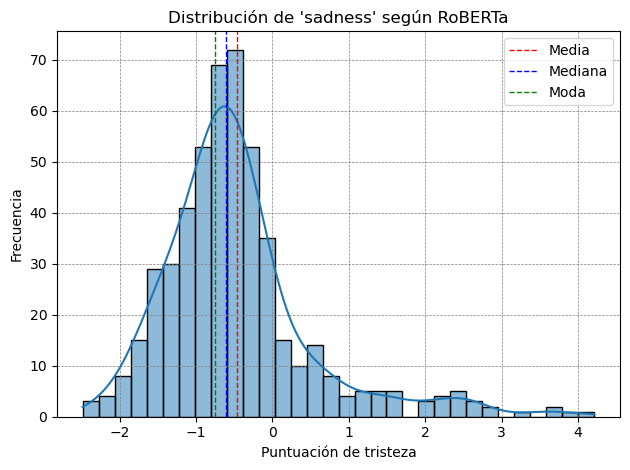

In [19]:
sns.histplot(moods["sadness"], kde=True)
plt.title("Distribución de 'sadness' según RoBERTa")
# Grid
plt.grid(visible=True, color="gray", linestyle="--", linewidth=0.5)
plt.axvline(moods["sadness"].mean(), color="red", linestyle="--", linewidth=1, label="Media")
plt.axvline(moods["sadness"].median(), color="blue", linestyle="--", linewidth=1, label="Mediana")
plt.axvline(moods["sadness"].mode()[0], color="green", linestyle="--", linewidth=1, label="Moda")
plt.legend()
plt.xlabel("Puntuación de tristeza")
plt.ylabel("Frecuencia")
plt.title("Distribución de 'sadness' según RoBERTa")
plt.tight_layout()
plt.grid(visible=True, color="gray", linestyle="--", linewidth=0.5)
# Guardar en imagen jpg
plt.savefig("../img/roberta-sadness.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [20]:
# Guardar el modelo y el tokenizer
joblib.dump(model, "../model/sentiment_roberta_model.joblib")
joblib.dump(tokenizer, "../model/sentiment_roberta_tokenizer.joblib")

['../model/sentiment_roberta_tokenizer.joblib']

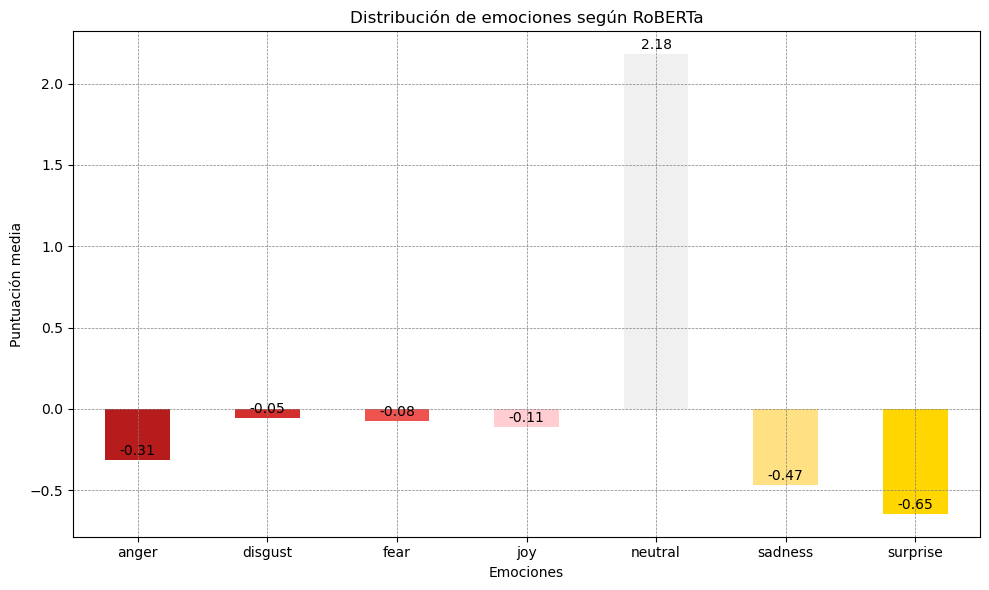

In [21]:
# Mejorar la gráfica en barras mostrando los valores encima de cada barra con separación vertical

sentiment_colors = { 
    "anger": "#b71c1c",  # Rojo muy oscuro (máx. negatividad)
    "disgust": "#d32f2f",  # Rojo oscuro
    "fear": "#ef5350",  # Rojo algo más claro
    "sadness": "#ffcdd2",  # Tono salmón muy claro
    "neutral": "#f0f0f0",  # Gris muy claro (punto de transición)
    "surprise": "#ffe082",  # Amarillo pastel
    "joy": "#ffd600"  # Amarillo vivo (máx. positividad)
}

# Calcular los valores promedio de las emociones
emotion_means = moods.iloc[:, 3:10].mean()

# Crear la gráfica
ax = emotion_means.plot(
    kind="bar", 
    color=sentiment_colors.values(), 
    figsize=(10, 6)
)

# Añadir valores encima de cada barra con separación vertical
for i, value in enumerate(emotion_means):
    ax.text(i, value + 0.03, f"{value:.2f}", ha="center", fontsize=10)  # Separación ajustada con +0.03

# Configurar título, etiquetas y diseño
plt.title("Distribución de emociones según RoBERTa")
plt.xlabel("Emociones")
plt.ylabel("Puntuación media")
plt.xticks(rotation=0)
plt.grid(visible=True, color="gray", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Guardar la gráfica como imagen
plt.savefig("../img/roberta-emotions.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [22]:
# Calcular los valores promedio de las emociones
emotion_means = moods.iloc[:, 3:10].mean()

# Mostrar los valores promedio
print(emotion_means)

anger      -0.312997
disgust    -0.054397
fear       -0.076100
joy        -0.109492
neutral     2.181019
sadness    -0.468258
surprise   -0.645629
dtype: float32
